In [27]:
!pip install xgboost

In [2]:
pwd

'/home/jabulani/House_Prices'

# Импорт библиотек

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation, DBSCAN, AgglomerativeClustering
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
from IPython.display import Image
from umap import UMAP
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier

In [8]:
def concat(train_data, test_data):
    ''' Функция соединяет несколько датасетов в один. '''
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def second_concat(train_data, test_data):
    ''' Фукция соединяет числовой и строковый датасеты. '''
    return pd.concat([train_data, test_data], axis=1, sort=True).reset_index(drop=True)

def separate(all_data):
    ''' Функция разделяет датасет на обучающий и валидационный. '''
    return all_data.loc[:1459], all_data.loc[1460:].drop(['SalePrice'], axis=1)

In [19]:
def fill_empty(df):
    '''Функция заполняет пропуски в датасете'''
    for i in df.columns:
        if df[i].dtype == 'O':
            df[i] = df[i].fillna('missed')
        else:
            df[i] = df[i].fillna(0) 
    return df

In [9]:
def OneHotEncoding(df):
    '''Функция производит Encoding'''
    for i in df.columns:
        if df[i].dtype == 'O' and i != 'SalePrice':
            df = pd.concat([df, pd.get_dummies(df[i], prefix=(i+'M'))], axis=1)
            df.drop(i, axis=1, inplace=True)
    return df

# Чтение файлов

In [11]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Распредление цены

/home/jabulani/Elbrus/git_Elbrus/ds_bootcamp/ds_bootcamp_venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


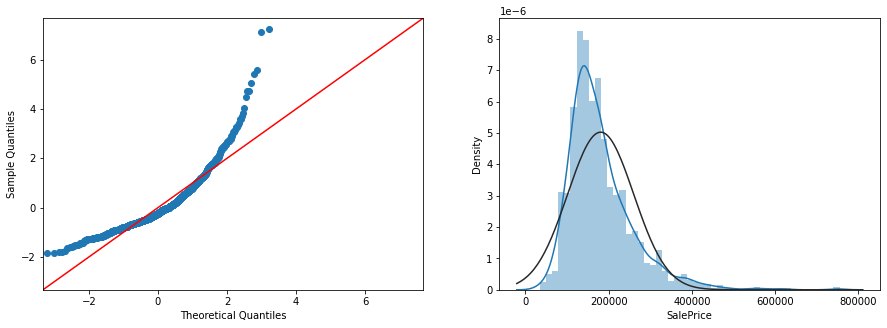

In [12]:
fig, ax = plt.subplots(1,2, figsize= (15,5))
sm.qqplot(df_train.SalePrice, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])
sns.distplot(df_train.SalePrice, kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

## Логарифмируем

/home/jabulani/Elbrus/git_Elbrus/ds_bootcamp/ds_bootcamp_venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


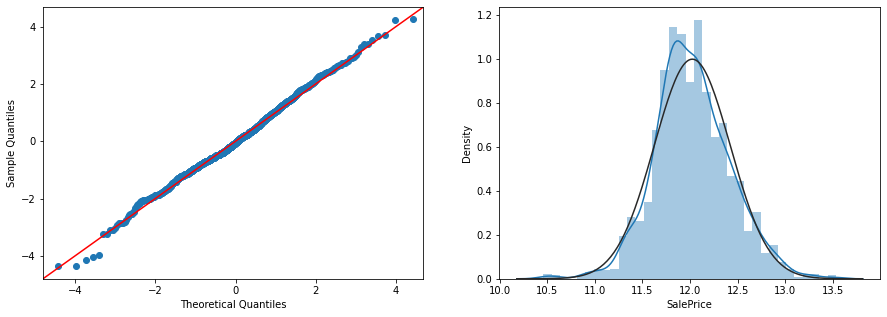

In [13]:
fig, ax = plt.subplots(1,2, figsize= (15,5))
sm.qqplot(np.log(df_train.SalePrice ), stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])
sns.distplot(np.log(df_train.SalePrice), kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

## Удаление ID, обучение

In [14]:
df_train.drop('Id', axis=1, inplace=True)
df_test.drop('Id', axis=1, inplace=True)

In [15]:
df_number_train = df_train.select_dtypes(exclude=[object])
df_str_train = df_train.select_dtypes(include=[object])
df_number_test = df_test.select_dtypes(exclude=[object])
df_str_test = df_test.select_dtypes(include=[object])

In [16]:
'''Добавляем возраст дома, сколько лет прошло с момента последнего ремонта и суммируем доступные площади'''
df_number_train['House_age'] = 2021 - df_number_train.YearBuilt
df_number_train['Remod_age'] = 2021 - df_number_train.YearRemodAdd
df_number_train['Sold_age'] = 2021 - df_number_train.YrSold
df_number_house_train = df_number_train[['MasVnrArea','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','1stFlrSF',
                           '2ndFlrSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF',
                            'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea']]
df_number_train['house_sum'] = df_number_house_train.sum(axis=1)

df_number_test['House_age'] = 2021 - df_number_test.YearBuilt
df_number_test['Remod_age'] = 2021 - df_number_test.YearRemodAdd
df_number_test['Sold_age'] = 2021- df_number_test.YrSold
df_number_house_test = df_number_test[['MasVnrArea','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','1stFlrSF',
                            '2ndFlrSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF',
                            'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea']]
df_number_test['house_sum'] = df_number_house_test.sum(axis=1)

/tmp/ipykernel_25118/2443175509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_number_train['House_age'] = 2021 - df_number_train.YearBuilt
/tmp/ipykernel_25118/2443175509.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_number_train['Remod_age'] = 2021 - df_number_train.YearRemodAdd
/tmp/ipykernel_25118/2443175509.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [25]:
a = 454
print(f'{a = }')

a = 454


In [18]:
target = 'SalePrice'
df_number_train = fill_empty(df_number_train)
df_number_test = fill_empty(df_number_test)

/tmp/ipykernel_25118/2259486841.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = df[i].fillna(0)


In [21]:
df_train_X_pre = df_number_train.drop('SalePrice', axis=1)
df_train_Y_pre = df_number_train[target]

X_pre, Y_pre = df_train_X_pre.to_numpy(), df_train_Y_pre.to_numpy()
Y_pre = np.log(Y_pre)
X_test_pre = df_number_test.to_numpy()

xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=3000,
                       max_depth=3,
                       gamma=0,
                       colsample_bytree=0.7,
                       scale_pos_weight=1,
                       reg_alpha=0.00006,
                       objective='reg:squarederror')
model_pre = xgboost.fit(X_pre,Y_pre)
print(f'{r2_score(Y_pre,xgboost.predict(X_pre)) = }')
Final_XGBR_pre = np.exp(xgboost.predict(X_test_pre))

df_number_test['SalePrice'] = Final_XGBR_pre

NameError: name 'XGBRegressor' is not defined